In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

pd.set_option('display.max_columns',14)

In [2]:
operations = pd.read_csv("data/operations/operations_cleaned.csv", low_memory=False)
weapons = pd.read_csv('data/operations/weapon.csv', encoding='latin-1')
aircrafts = pd.read_csv("data/operations/aircraft.csv", encoding='latin-1')

In [3]:
len(operations.columns)

47

# 1. Importing data

In [4]:
# Operation data
operations.head(5)

,THOR_DATA_VIET_ID,COUNTRYFLYINGMISSION,MILSERVICE,MSNDATE,SOURCEID,SOURCERECORD,VALID_AIRCRAFT_ROOT,...,NUMWEAPONSJETTISONED,NUMWEAPONSRETURNED,RELEASEALTITUDE,RELEASEFLTSPEED,RESULTSBDA,TIMEOFFTARGET,WEAPONSLOADEDWEIGHT
0,351,UNITED STATES OF AMERICA,USAF,1971-06-05,647464,SEADAB,EC-47,...,-1,-1,NaN,NaN,NaN,1005.0,0
1,2,UNITED STATES OF AMERICA,USAF,1972-12-26,642778,SEADAB,EC-47,...,-1,-1,NaN,NaN,NaN,530.0,0
2,3,UNITED STATES OF AMERICA,USAF,1973-07-28,642779,SEADAB,RF-4,...,-1,-1,NaN,NaN,NaN,730.0,0
3,4,UNITED STATES OF AMERICA,USAF,1970-02-02,642780,SEADAB,A-1,...,-1,-1,NaN,NaN,SECONDARY FIRE,1415.0,17400
4,5,VIETNAM (SOUTH),VNAF,1970-10-08,642781,SEADAB,A-37,...,-1,-1,NaN,NaN,RNO WEATHER,1240.0,0


operations.columns

THOR_DATA_VIET_ID       COUNTRYFLYINGMISSION     MILSERVICE               MSNDATE
SOURCEID                SOURCERECORD             VALID_AIRCRAFT_ROOT      TAKEOFFLOCATION
TGTLATDD_DDD_WGS84      TGTLONDDD_DDD_WGS84      TGTTYPE                  NUMWEAPONSDELIVERED
TIMEONTARGET            WEAPONTYPE               WEAPONTYPECLASS          WEAPONTYPEWEIGHT
AIRCRAFT_ORIGINAL       AIRCRAFT_ROOT            AIRFORCEGROUP            AIRFORCESQDN
CALLSIGN                FLTHOURS                 MFUNC                    MFUNC_DESC
MISSIONID               NUMOFACFT                OPERATIONSUPPORTED       PERIODOFDAY
UNIT                    TGTCLOUDCOVER            TGTCONTROL               TGTCOUNTRY
TGTID                   TGTORIGCOORDS            TGTORIGCOORDSFORMAT      TGTWEATHER
ADDITIONALINFO          GEOZONE                  ID                       MFUNC_DESC_CLASS
NUMWEAPONSJETTISONED    NUMWEAPONSRETURNED       RELEASEALTITUDE          RELEASEFLTSPEED
RESULTSBDA              TIMEOFFTARGET            WEAPONSLOADEDWEIGHT


In [5]:
# Weapon data
weapons.head(5)

,WEAPON_ID,WEAPONTYPE,WEAPONTYPE_COMMON_NAME,WEAPON_CLASS,WEAPONTYPE_DESC,WEAPON_COUNT
0,1,100 GP,General Purpose Bomb,BOMB,100 lb general purpose,1
1,2,1000 G,Megaboller flash powder bomb,BOMB,1000 g BKS,2
2,3,1000LB GP M-65,An-M65,BOMB,1000 lb general purpose,12776
3,4,1000LB MK-83,Mark 83 bomb,BOMB,1000 lb none guidence general purpose bomb,15522
4,5,1000LB SAP M59,AN-M59,BOMB,1000 lb semi-armor piercing bomb,454


In [6]:
# Aircraft data
aircrafts.head(5)

,GLOSS_ID,VALIDATED_ROOT,AIRCRAFT_NAME,WEBSITE_LINK,AIRCRAFT_TYPE,AIRCRAFT_SHORTNAME,AIRCRAFT_APPLICATION,AC_MISSION_COUNT
0,1,A-1,Douglas A-1 Skyraider,http://www.navalaviationmuseum.org/attractions...,Fighter Jet,Skyraider,FIGHTER,373265
1,2,A-26,Douglas A-26 Invader,http://www.militaryfactory.com/aircraft/detail...,Light Bomber,Invader,BOMBER,36672
2,4,A-37,Cessna A-37 Dragonfly,http://www.militaryfactory.com/aircraft/detail...,Light ground-attack aircraft,Dragonfly,ATTACK,282699
3,5,A-4,McDonnell Douglas A-4 Skyhawk,http://www.fighter-planes.com/info/a4-skyhawk.htm,Fighter Jet,Skyhawk,FIGHTER,390290
4,6,A-5,North American A-5 Vigilante,http://www.militaryfactory.com/aircraft/detail...,Bomber Jet,Vigilante,BOMBER,10


# 2. Data cleaning and processing
* Since we only care about UXO, we should select weapons that contain explosives like rocket or bombs

## 2.1. Viewing the weapon data in weapons.csv

In [7]:
weapons['WEAPON_CLASS'].unique()

array(['BOMB', 'GUN', 'ROCKET', 'SUPPORT', 'MISSILE'], dtype=object)

## 2.2. Checking out weapons in used in operations

In [8]:
operations['WEAPONTYPECLASS'].unique() # Weapon class is not available in operations data

array([nan])

In [9]:
weapon_in_operations = operations['WEAPONTYPE'].unique() # At least weapon type is available
print(f"There are {len(weapon_in_operations)} types of weapon used")
print(weapon_in_operations[:5])

There are 295 types of weapon used
[nan 'BLU27 FIRE BOMB (750)' 'MK 82 GP BOMB (500) LD' 'CARGO (TONS)'
 'CBU24 AN PR/MT (BLU26)']


### We will mark WEAPONTYPECLASS using 'weapons' dataframe

In [10]:
weapon_type_and_class = weapons[['WEAPONTYPE', 'WEAPON_CLASS']]
weapon_type_and_class.head(5)

,WEAPONTYPE,WEAPON_CLASS
0,100 GP,BOMB
1,1000 G,BOMB
2,1000LB GP M-65,BOMB
3,1000LB MK-83,BOMB
4,1000LB SAP M59,BOMB


In [11]:
operations = operations.merge(weapon_type_and_class, on='WEAPONTYPE', how='left')

In [12]:
len(operations['WEAPON_CLASS'].notnull()) / len(operations['WEAPONTYPE'].notnull()) # verifies that all weapon type can be found in weapons

1.0

In [13]:
weapon_delivered = operations.groupby('WEAPON_CLASS')['NUMWEAPONSDELIVERED'].sum().sort_values(ascending=False)

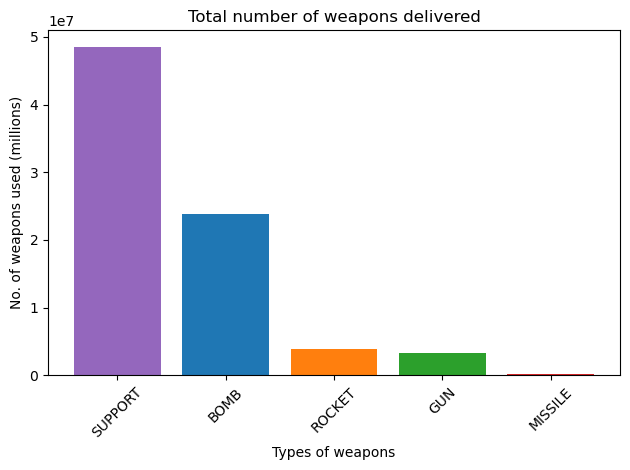

In [14]:
weapon_colors = {
    'BOMB': '#1f77b4',      # blue
    'ROCKET': '#ff7f0e',    # orange
    'GUN': '#2ca02c',       # green
    'MISSILE': '#d62728',   # red
    'SUPPORT': '#9467bd'    # purple
}

fig, ax = plt.subplots()

colors = [weapon_colors.get(w, '#7f7f7f') for w in weapon_delivered.index] 

ax.bar(weapon_delivered.index, weapon_delivered.values, color=colors)
ax.set_title("Total number of weapons delivered")
ax.set_xlabel("Types of weapons")
ax.set_ylabel("No. of weapons used (millions)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
np.sum(operations['WEAPONTYPEWEIGHT'] * operations['NUMWEAPONSDELIVERED']) / 2000

8217195.461

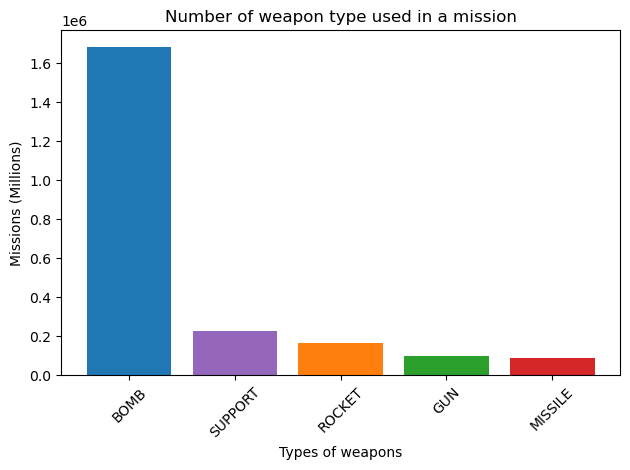

In [15]:
weapon_class_count = weapons.groupby('WEAPON_CLASS', sort=True)['WEAPON_COUNT'].sum()
weapon_class_count = weapon_class_count.sort_values(ascending=False)
fig, ax = plt.subplots()

colors = [weapon_colors.get(w, '#7f7f7f') for w in weapon_class_count.index] 

ax.bar(weapon_class_count.index, weapon_class_count.values, color=colors)
ax.set_title("Number of weapon type used in a mission")
ax.set_xlabel("Types of weapons")
ax.set_ylabel("Missions (Millions)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.3. Dealing with coordinate data field
Since we are analyzing REGIONS with high UXO risk it is important that we need to know the locations so maybe we will drop all samples without the coordinate

In [16]:
total_entries = len(operations)
available_ratio = operations[operations != 'NaN'].count() / total_entries * 100
available_ratio.sort_values(ascending=False)

THOR_DATA_VIET_ID       100.000000
NUMWEAPONSRETURNED      100.000000
NUMOFACFT               100.000000
WEAPONTYPEWEIGHT        100.000000
ADDITIONALINFO          100.000000
ID                      100.000000
MFUNC_DESC_CLASS        100.000000
NUMWEAPONSDELIVERED     100.000000
FLTHOURS                100.000000
NUMWEAPONSJETTISONED    100.000000
WEAPONSLOADEDWEIGHT     100.000000
VALID_AIRCRAFT_ROOT     100.000000
SOURCERECORD            100.000000
SOURCEID                100.000000
MSNDATE                 100.000000
AIRCRAFT_ORIGINAL        99.989680
AIRCRAFT_ROOT            99.989680
UNIT                     99.989444
MILSERVICE               99.930434
COUNTRYFLYINGMISSION     99.922598
TAKEOFFLOCATION          99.893564
MISSIONID                99.664484
TIMEOFFTARGET            99.434119
TIMEONTARGET             99.434119
MFUNC                    97.835075
MFUNC_DESC               97.757759
PERIODOFDAY              95.722779
TGTCOUNTRY               95.358572
TGTORIGCOORDS       

THOR_DATA_VIET_ID       100.000000   NUMWEAPONSRETURNED      100.000000   NUMOFACFT               100.000000   WEAPONTYPEWEIGHT        100.000000
ADDITIONALINFO          100.000000   ID                      100.000000   MFUNC_DESC_CLASS        100.000000   NUMWEAPONSDELIVERED     100.000000
FLTHOURS                100.000000   NUMWEAPONSJETTISONED    100.000000   WEAPONSLOADEDWEIGHT     100.000000   VALID_AIRCRAFT_ROOT     100.000000
SOURCERECORD            100.000000   SOURCEID                100.000000   MSNDATE                 100.000000   AIRCRAFT_ORIGINAL        99.989680
AIRCRAFT_ROOT            99.989680   UNIT                     99.989444   MILSERVICE               99.930434   COUNTRYFLYINGMISSION     99.922598
TAKEOFFLOCATION          99.893564   MISSIONID                99.664484   TIMEOFFTARGET            99.434119   TIMEONTARGET             99.434119
MFUNC                    97.835075   MFUNC_DESC               97.757759   PERIODOFDAY              95.722779   TGTCOUNTRY               95.358572
TGTORIGCOORDS            77.128183   TGTORIGCOORDSFORMAT      76.600157   TGTLATDD_DDD_WGS84       75.802348   TGTLONDDD_DDD_WGS84      75.802348
GEOZONE                  74.990408   TGTTYPE                  60.808095   OPERATIONSUPPORTED       58.889123   TGTCONTROL               53.953074
WEAPONTYPE               48.537839   WEAPON_CLASS             48.533493   TGTCLOUDCOVER            47.750950   TGTWEATHER               44.486508
CALLSIGN                 29.335610   RESULTSBDA                6.110719   RELEASEALTITUDE           0.072328   AIRFORCEGROUP             0.062264
AIRFORCESQDN              0.059566   RELEASEFLTSPEED           0.036164   TGTID                     0.000749   WEAPONTYPECLASS           0.000000

### We can see that 75% of the samples have  coordinate data, we should investigate why the other 25% samples don't have coordinate data

In [17]:
operations_with_coords = operations[operations['TGTLONDDD_DDD_WGS84'].notnull()]
operations_without_coords = operations[operations['TGTLONDDD_DDD_WGS84'].isnull()]

In [18]:
import pandas as pd

def TVD(df1, df2, column):
    dist1 = df1[column].value_counts(normalize=True)
    dist2 = df2[column].value_counts(normalize=True)

    all_categories = set(dist1.index).union(dist2.index)

    tvd = 0.5 * sum(abs(dist1.get(cat, 0) - dist2.get(cat, 0)) for cat in all_categories)
    return tvd

In [19]:
tvd_df = pd.DataFrame({
    'Column' : operations_with_coords.columns,
    'TVD' : [TVD(operations_with_coords, operations_without_coords, col) for col in operations_with_coords.columns]
})


KeyboardInterrupt



In [ ]:
tvd_df = tvd_df.sort_values('TVD', ascending=False)

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(tvd_df['Column'], tvd_df['TVD'], color='skyblue')

# Add horizontal line
plt.axhline(y=0.5, color='red', linestyle='--', label='TVD = 0.5 threshold')
plt.axhline(y=0.4, color='green', linestyle='--', label='TVD = 0.4 threshold')
plt.axhline(y=0.6, color='blue', linestyle='--', label='TVD = 0.6 threshold')
# Labels and grid
plt.xlabel('Feature')
plt.ylabel('Total Variation Distance')
plt.title('TVD Between Records With and Without Coordinates')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### We can see that the majority of TVD distance is over 40%
- Values like IDs have high uniqueness and doesn't contribute anything to TVD comparison so we will not include that in the mean TVD.
- Values like coordinate also behave like ID but are necessary, so instead of using raw coordinates, we use the GEOZONE feature.

In [ ]:
scores = []
for col, score in zip(tvd_df['Column'], tvd_df['TVD']):
    if col in ['ID', 'THOR_DATA_VIET_ID', 'Unamed: 0', 'TGTORIGCOORDS', 'TGTLATDD_DDD_WGS84', 'TGTLONDDD_DDD_WGS84']:
        continue
    else:
        scores.append(score)

print(f"The mean TVD is: {np.mean(scores)}")

### High TVD indicates that the data is not missing at random so there might be some pattern here
- The high TVD scores across most features suggest that the data is not missing at random (NMAR) — there likely exists a systematic pattern in the missingness of coordinate data.
- The low TVD for WEAPONTYPE_CLASS indicates that this specific feature's distribution is relatively similar between the two groups (with and without coordinates), meaning weapon type alone does not explain the missingness.
- Therefore, the 25% of records with missing coordinates appear to differ significantly from the rest of the dataset in many other dimensions — they might reflect a different operational context, data collection procedure, or reporting bias.
### We need to further investigate the data based on coordinate to:
- See whether these missing cases represent non-dropped bombs, covert missions, different regions, or lower reporting standards.
- What potential impact excluding them might have on UXO risk analysis.

### Comparing feature availability between the sample group with coordinate and without coordinate

In [ ]:
def checkAvailability(df):
    total_entries = len(df)
    available_ratio = df[df != 'NaN'].count() / total_entries * 100
    return available_ratio.sort_values(ascending=False)

In [ ]:
ops_without_coords_availability = checkAvailability(operations_without_coords)
ops_with_coords_availability = checkAvailability(operations_with_coords)

In [ ]:
# Combine into one DataFrame
availability_df = pd.DataFrame({
    'With Coordinates': ops_with_coords_availability,
    'Without Coordinates': ops_without_coords_availability
}).fillna(0)  # Fill missing values with 0 in case some columns are not present

# Sort by availability in one group for consistent ordering
availability_df = availability_df.sort_values(by='With Coordinates')

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

availability_df.plot.barh(ax=ax, width=0.8)
ax.set_xlabel('Availability (%)')
ax.set_title('Feature Availability: With vs Without Coordinates')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
threshold = 5  # in percent

availability_df['Difference'] = (availability_df['With Coordinates'] - availability_df['Without Coordinates']).abs()

# Filter based on threshold
filtered_df = availability_df[availability_df['Difference'] > threshold].drop(columns='Difference')
filtered_df = filtered_df.sort_values(by='With Coordinates')

fig, ax = plt.subplots(figsize=(15, len(filtered_df) * 0.4))
filtered_df.plot.barh(ax=ax, width=0.8)
ax.set_xlabel('Availability (%)')
ax.set_title(f'Feature Availability (Difference > {threshold}%)')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### The availability comparison shows that the sample group with missing coordinates still holds crucial information which are:
- Target Country: The data not only contains bombs dropped in Vietnam but also in other countries in the Indochina. Although we don't know where exactly the bomb was dropped but we still know it's somewhere in Vietnam and not other countries.
- WEAPON_TYPE and WEAPON_CLASS: In this graph we can see that the missing group's weapon availability is about half of the other group, this indicate that if we dropped this data we are missing on **1/3 of the weapons delieverd.**

### Investigating individual fields with high TVD
- We will investigate some fields that might explains why 25% of coordinate is missing and does the 25% missing data hold any importance in UXO risk analysis.

#### MFUCN_DESC

- These two graphs indicate that most missions with coordinates are attack missions, whereas those without coordinates are primarily non-combat operations such as training, maintenance, or reconnaissance — which typically do not involve bomb usage. Based on this insight, it may be reasonable to consider excluding missions without coordinates from further analysis.

In [ ]:
import matplotlib.ticker as mtick

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

top_mfunc_with_coords = (operations_with_coords['MFUNC_DESC'].value_counts() / len(operations_with_coords)).head(10)
axes[0].barh(top_mfunc_with_coords.index, top_mfunc_with_coords.values * 100.0)
axes[0].set_title('Top 10 Missions with Coordinates')
axes[0].invert_yaxis()
axes[0].grid(True, axis='x', linestyle='--')
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter())

top_mfunc_without_coords = (operations_without_coords['MFUNC_DESC'].value_counts() / len(operations_without_coords)).head(10)
axes[1].barh(top_mfunc_without_coords.index, top_mfunc_without_coords.values * 100.0)
axes[1].set_title('Top 10 Missions without Coordinates')
axes[1].invert_yaxis()
axes[1].grid(True, axis='x', linestyle='--')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter())

plt.tight_layout()
plt.show()


#### WEAPON_CLASS

In [ ]:
ops_weapon_class = pd.DataFrame({
    'with_coords': operations_with_coords['WEAPON_CLASS'].value_counts(),
    'without_coords': operations_without_coords['WEAPON_CLASS'].value_counts()
}).fillna(0)

categories = ops_weapon_class.index
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(x - width/2, ops_weapon_class['with_coords'], width, label='With Coordinates')
ax.bar(x + width/2, ops_weapon_class['without_coords'], width, label='Without Coordinates')

ax.set_title('Weapon Class Count')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
ops_weapon_class_prop = ops_weapon_class.div(ops_weapon_class.sum(axis=0), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].pie(ops_weapon_class_prop['with_coords'], labels=ops_weapon_class_prop.index,
            autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors[:len(ops_weapon_class_prop.index)])
axes[0].set_title('Weapon Class Proportions (With Coordinates)')

axes[1].pie(ops_weapon_class_prop['without_coords'], labels=ops_weapon_class_prop.index,
            autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors[:len(ops_weapon_class_prop.index)])
axes[1].set_title('Weapon Class Proportions (Without Coordinates)')

plt.tight_layout()
plt.show()


#### MSNDATE

In [59]:
# Ensure you are working on a copy to avoid modifying a slice
operations_with_coords = operations_with_coords.copy()
operations_without_coords = operations_without_coords.copy()

# Now you can safely modify the 'YEAR' column
operations_with_coords.loc[:, 'YEAR'] = operations_with_coords['MSNDATE'].astype(str).str[:4].astype(int)
operations_without_coords.loc[:, 'YEAR'] = operations_without_coords['MSNDATE'].astype(str).str[:4].astype(int)

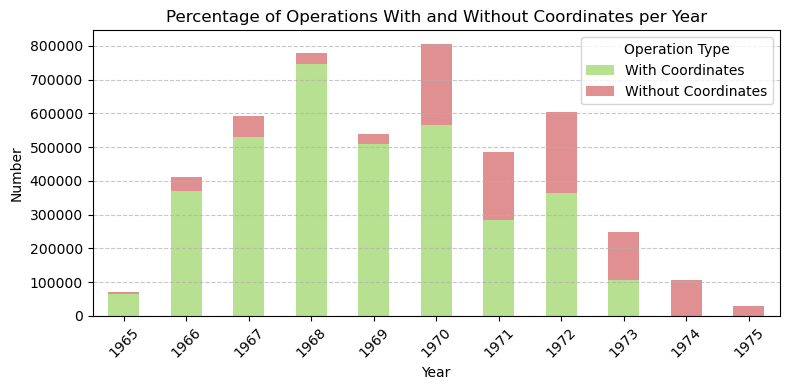

In [89]:
# Count per year for each group
count_with = operations_with_coords['YEAR'].value_counts()
count_without = operations_without_coords['YEAR'].value_counts()

# Combine into a single DataFrame, reindexing by all years seen in both
all_years = sorted(set(count_with.index).union(count_without.index))
df = pd.DataFrame({
    'With Coordinates': count_with ,
    'Without Coordinates': count_without
}, index=all_years).fillna(0)


ax = df.plot(kind='bar', stacked=True, figsize=(8, 4), color=['#b7e090', '#e09090'])
plt.title('Percentage of Operations With and Without Coordinates per Year')
plt.ylabel('Number')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.legend(title='Operation Type')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### KINETIC MISISON vs NON-KINETIC MISSIONS
- Some missions might carry explosives but they might be just trasportation missions. This fields tells us whether the mission used the explosive for offensive purposes or not

In [61]:
strike_nonkinetic_count = operations.loc[
    (operations['MFUNC_DESC_CLASS'] == 'NONKINETIC') &
    (operations['MFUNC_DESC'] == 'STRIKE')
]

print(f"This simple query shows that no labeled as NONKINETIC is a STRIKE missions. \
The number of operations labeled as NONKINETIC and is a STRIKE MISSIONS is {len(strike_nonkinetic_count)}")

This simple query shows that no labeled as NONKINETIC is a STRIKE missions. The number of operations labeled as NONKINETIC and is a STRIKE MISSIONS is 0


In [62]:
kinetic_missions_with_coords = operations_with_coords[operations_with_coords['MFUNC_DESC_CLASS'] == 'KINETIC']
non_kinetic_missions_with_coords = operations_with_coords[operations_with_coords['MFUNC_DESC_CLASS'] == 'NONKINETIC']

kinetic_missions_without_coords = operations_without_coords[operations_without_coords['MFUNC_DESC_CLASS'] == 'KINETIC']
non_kinetic_missions_without_coords = operations_without_coords[operations_without_coords['MFUNC_DESC_CLASS'] == 'NONKINETIC']

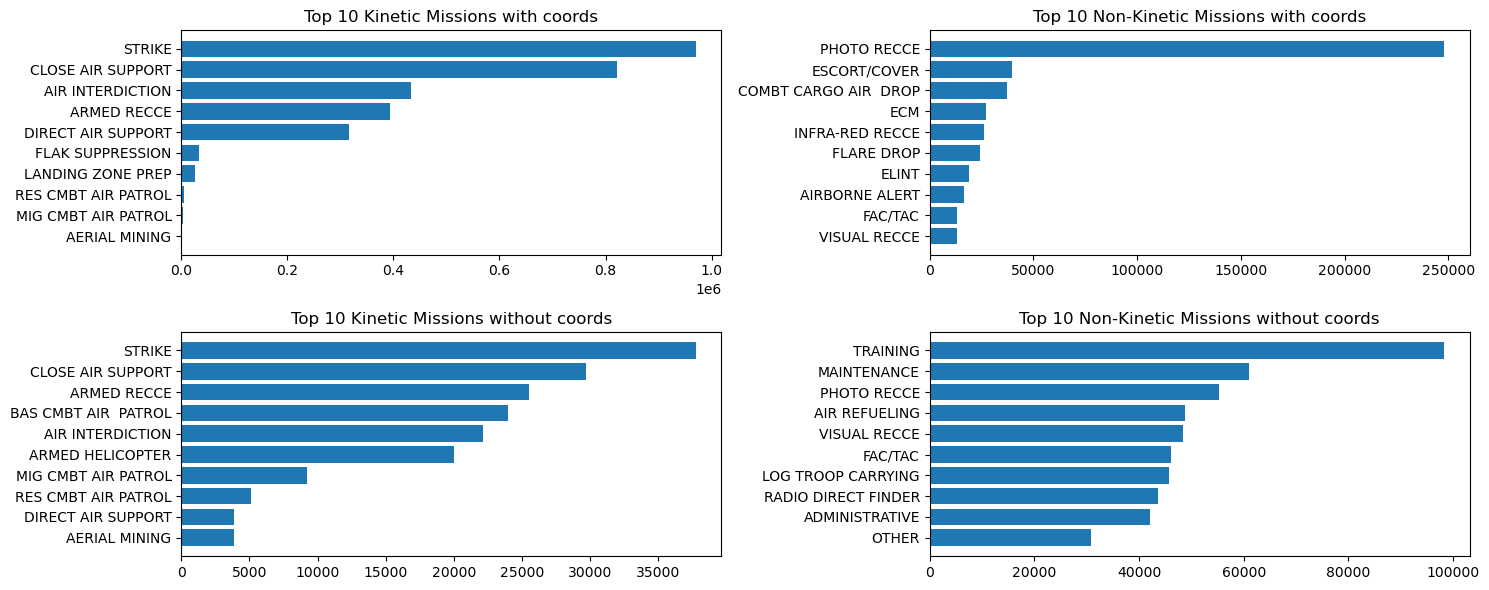

In [63]:
top_kinetic_missions_with_coords = kinetic_missions_with_coords['MFUNC_DESC'].value_counts().head(10)
top_non_kinetic_missions_with_coords = non_kinetic_missions_with_coords['MFUNC_DESC'].value_counts().head(10)
top_kinetic_missions_without_coords = kinetic_missions_without_coords['MFUNC_DESC'].value_counts().head(10)
top_non_kinetic_missions_without_coords = non_kinetic_missions_without_coords['MFUNC_DESC'].value_counts().head(10)

top_kinetic_missions_with_coords = top_kinetic_missions_with_coords.iloc[::-1]
top_non_kinetic_missions_with_coords = top_non_kinetic_missions_with_coords.iloc[::-1]
top_kinetic_missions_without_coords = top_kinetic_missions_without_coords.iloc[::-1]
top_non_kinetic_missions_without_coords = top_non_kinetic_missions_without_coords.iloc[::-1]

fig, ax = plt.subplots(2, 2, figsize=(15, 6))

# Bar plot for kinetic missions
ax[0][0].barh(top_kinetic_missions_with_coords.index, top_kinetic_missions_with_coords.values)
ax[0][0].set_title('Top 10 Kinetic Missions with coords')

# Bar plot for non-kinetic missions
ax[0][1].barh(top_non_kinetic_missions_with_coords.index, top_non_kinetic_missions_with_coords.values)
ax[0][1].set_title('Top 10 Non-Kinetic Missions with coords')

# Bar plot for kinetic missions
ax[1][0].barh(top_kinetic_missions_without_coords.index, top_kinetic_missions_without_coords.values)
ax[1][0].set_title('Top 10 Kinetic Missions without coords')

# Bar plot for non-kinetic missions
ax[1][1].barh(top_non_kinetic_missions_without_coords.index, top_non_kinetic_missions_without_coords.values)
ax[1][1].set_title('Top 10 Non-Kinetic Missions without coords')

plt.tight_layout()
plt.show()

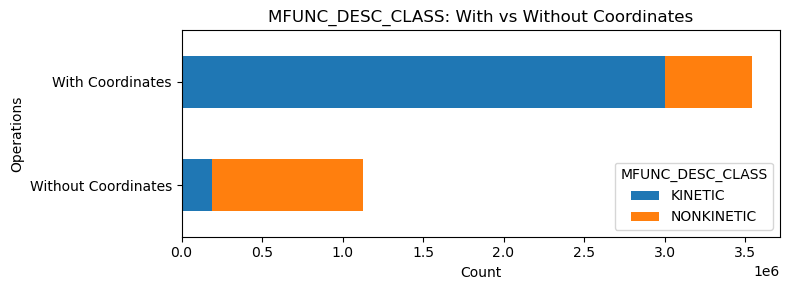

In [64]:
df_stacked = pd.DataFrame({
    'Without Coordinates': operations_without_coords['MFUNC_DESC_CLASS'].value_counts(),
    'With Coordinates': operations_with_coords['MFUNC_DESC_CLASS'].value_counts()
}).T

df_stacked.plot(kind='barh', stacked=True, figsize=(8, 3))  # barh instead of bar

plt.title('MFUNC_DESC_CLASS: With vs Without Coordinates')
plt.xlabel('Count')
plt.ylabel('Operations')
plt.legend(title='MFUNC_DESC_CLASS')
plt.tight_layout()
plt.show()


### CONCLUSION: 
- The majority of data with missiong coordinate doesn't contain bomb, if it does they are mostly NONKINETIC missions that are responsible explosives transportation and such.
- Data with missing coordinates has no value in spatial analysis.
- However, many missions without coordinates still carries a great amount of explosives so we it can be useful for statistical analysis.
- Besides, we cannot rule out the probability of UXO being dropped by non combative missions.

## 3. Areas' risk analysis

### a. Plotting the operations with coords

I will extract a few columns from data of operations with coordinates to plot in kepler.gl, since kepler.gl can't handle large files.

In [65]:
operations_with_coords.columns

Index(['THOR_DATA_VIET_ID', 'COUNTRYFLYINGMISSION', 'MILSERVICE', 'MSNDATE',
       'SOURCEID', 'SOURCERECORD', 'VALID_AIRCRAFT_ROOT', 'TAKEOFFLOCATION',
       'TGTLATDD_DDD_WGS84', 'TGTLONDDD_DDD_WGS84', 'TGTTYPE',
       'NUMWEAPONSDELIVERED', 'TIMEONTARGET', 'WEAPONTYPE', 'WEAPONTYPECLASS',
       'WEAPONTYPEWEIGHT', 'AIRCRAFT_ORIGINAL', 'AIRCRAFT_ROOT',
       'AIRFORCEGROUP', 'AIRFORCESQDN', 'CALLSIGN', 'FLTHOURS', 'MFUNC',
       'MFUNC_DESC', 'MISSIONID', 'NUMOFACFT', 'OPERATIONSUPPORTED',
       'PERIODOFDAY', 'UNIT', 'TGTCLOUDCOVER', 'TGTCONTROL', 'TGTCOUNTRY',
       'TGTID', 'TGTORIGCOORDS', 'TGTORIGCOORDSFORMAT', 'TGTWEATHER',
       'ADDITIONALINFO', 'GEOZONE', 'ID', 'MFUNC_DESC_CLASS',
       'NUMWEAPONSJETTISONED', 'NUMWEAPONSRETURNED', 'RELEASEALTITUDE',
       'RELEASEFLTSPEED', 'RESULTSBDA', 'TIMEOFFTARGET', 'WEAPONSLOADEDWEIGHT',
       'WEAPON_CLASS', 'YEAR'],
      dtype='object')

In [66]:
selected_columns = [
    'TGTLATDD_DDD_WGS84', 'TGTLONDDD_DDD_WGS84', 'MSNDATE', 'NUMWEAPONSDELIVERED', 'NUMOFACFT', 
    'OPERATIONSUPPORTED', 'PERIODOFDAY', 'TGTCOUNTRY', 'TGTWEATHER', 'WEAPON_CLASS', 'YEAR',
    'MFUNC_DESC', 'MFUNC_DESC_CLASS'
]

# Rename latitude and longitude columns
# renamed_df = operations_with_coords[selected_columns].rename(columns={
#     'TGTLATDD_DDD_WGS84': 'lat',
#     'TGTLONDDD_DDD_WGS84': 'lon'
# })

# Export to CSV
# renamed_df.to_csv('graph_images/ops_coords.csv', index=False)


<div style="display: flex; justify-content: center;">

  <div style="text-align: center; width: 100%; max-width: 800px;">
    <img src="graph_images/overview.png" alt="Image 1" style="width: 100%; object-fit: cover;">
    <p>Map of all missions in US Airforce missions</p>
  </div>

</div>


By looking at the plot of flight missions we can see the following things:
- The bombming pattern follows certain areas, or along certain targets along rivers, we can assume that most target are related to supply transportation.
- There are certain city were targeted like Phonsavan city in Laos, Ho Chi Minh city, the Central Region of Vietnam, and along Vietnam's coast line

In [67]:
tgtcountry_dist = operations_with_coords['TGTCOUNTRY'].value_counts()
tgtcountry_dist

TGTCOUNTRY
SOUTH VIETNAM     1658617
LAOS              1087019
NORTH VIETNAM      607482
CAMBODIA           147097
THAILAND             2574
WESTPAC WATERS         73
UNKNOWN                45
PHILLIPINES             1
Name: count, dtype: int64

- Our goal is to analyze UXO risk in Vietnam only, we need to remove all data that is outside of the country

<div style="display: flex; justify-content: space-between; align-items: flex-start;">

  <div style="text-align: center; flex: 1; margin: 0 10px;">
    <img src="graph_images/filter_tgtcountry_cambodia.png" alt="Image 1" style="height: 400px; object-fit: cover;">
    <p>TGTCOUNTRY = CAMBODIA</p>
  </div>

  <div style="text-align: center; flex: 1; margin: 0 10px;">
    <img src="graph_images/filter_tgtcountry_laos.png" alt="Image 2" style="height: 400px; object-fit: cover;">
    <p>TGTCOUNTRY = LAOS</p>
  </div>

  <div style="text-align: center; flex: 1; margin: 0 10px;">
    <img src="graph_images/filter_tgtcountry_vietnam.png" alt="Image 3" style="height: 400px; object-fit: cover;">
    <p>TGTCOUNTRY = VIETNAM</p>
  </div>

</div>


- By looking at this graph, we found out that we can no longer use the 25% of data with missing coordinates cannot be used for statistical analysis as TGTCOUNTRY field doesn't correspond to the exact coordinate.

#### Filtering out data with ADM0 geo data
- We will use data with coordinates within Vietnam land border, ans those that are 5km away from vietnam borders as there might be some error in coordinate exact misison execution.
- We determine 5km around border because we see that there are patterns of bombings that shows roads going through Vietnam borders.
- In missions like carpet bombing the boms might go across the borders along the route that leads into Vietnam from Laos or Cambodia.
- Also mission along the coastline of vietnam should be accounted for the same reason

<div style="display: flex; justify-content: space-between; align-items: flex-start;">

  <div style="text-align: center; flex: 1; margin: 0 10px;">
    <img src="graph_images/adm0_before.png" alt="Image 1" style="height: 400px; object-fit: cover;">
    <p>Mission coordinates before limiting to inside Vietnam</p>
  </div>

  <div style="text-align: center; flex: 1; margin: 0 10px;">
    <img src="graph_images/adm0_after.png" alt="Image 2" style="height: 400px; object-fit: cover;">
    <p>Mission coordinates within 5km away from Vietnam border</p>
  </div>

</div>


In [74]:
geometry = [Point(xy) for xy in zip(operations_with_coords['TGTLONDDD_DDD_WGS84'], operations_with_coords['TGTLATDD_DDD_WGS84'])]
gdf = gpd.GeoDataFrame(operations_with_coords, geometry=geometry, crs="EPSG:4326")

In [70]:
adm0 = gpd.read_file('data/geoborders/adm0/geoBoundaries-VNM-ADM0.geojson')
adm1 = gpd.read_file('data/geoborders/adm1/geoBoundaries-VNM-ADM1.geojson')
adm2 = gpd.read_file('data/geoborders/adm2/geoBoundaries-VNM-ADM2.geojson')

C:\Users\dummy\miniconda3\envs\deep-learning\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [68]:
bomb_with_coords = np.sum(operations_with_coords[operations_with_coords['WEAPON_CLASS'] == 'BOMB']['WEAPONTYPEWEIGHT'] * 
        operations_with_coords[operations_with_coords['WEAPON_CLASS'] == 'BOMB']['NUMWEAPONSDELIVERED']) / 2000

5904919.3525

In [69]:
bomb_without coords = np.sum(operations_without_coords[operations_without_coords['WEAPON_CLASS'] == 'BOMB']['WEAPONTYPEWEIGHT'] * 
        operations_without_coords[operations_without_coords['WEAPON_CLASS'] == 'BOMB']['NUMWEAPONSDELIVERED']) / 2000

199334.098

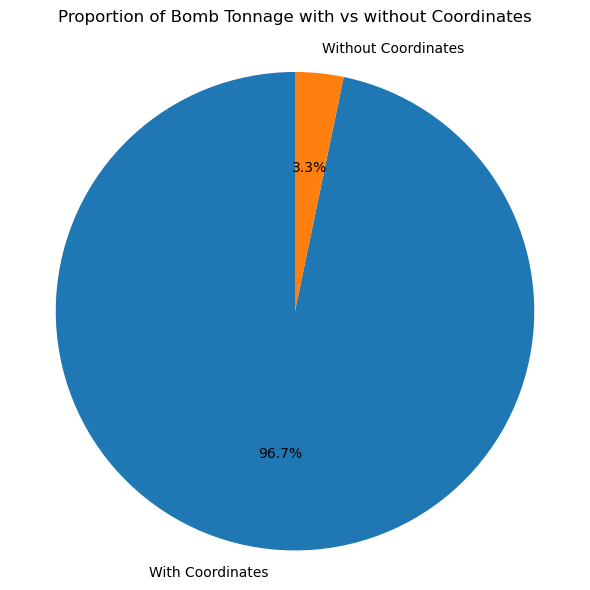

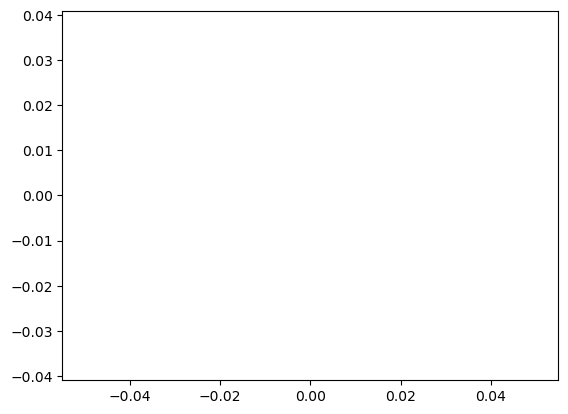

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Compute bomb tonnage in tons
bomb_with_coords = np.sum(
    operations_with_coords[operations_with_coords['WEAPON_CLASS'] == 'BOMB']['WEAPONTYPEWEIGHT'] *
    operations_with_coords[operations_with_coords['WEAPON_CLASS'] == 'BOMB']['NUMWEAPONSDELIVERED']
) / 2000

bomb_without_coords = np.sum(
    operations_without_coords[operations_without_coords['WEAPON_CLASS'] == 'BOMB']['WEAPONTYPEWEIGHT'] *
    operations_without_coords[operations_without_coords['WEAPON_CLASS'] == 'BOMB']['NUMWEAPONSDELIVERED']
) / 2000

bomb_total = np.sum(
    operations[operations['WEAPON_CLASS'] == 'BOMB']['WEAPONTYPEWEIGHT'] *
    operations[operations['WEAPON_CLASS'] == 'BOMB']['NUMWEAPONSDELIVERED']
) / 2000

# Sanity check to ensure all adds up
assert np.isclose(bomb_with_coords + bomb_without_coords, bomb_total, rtol=1e-2), "Totals don't match"

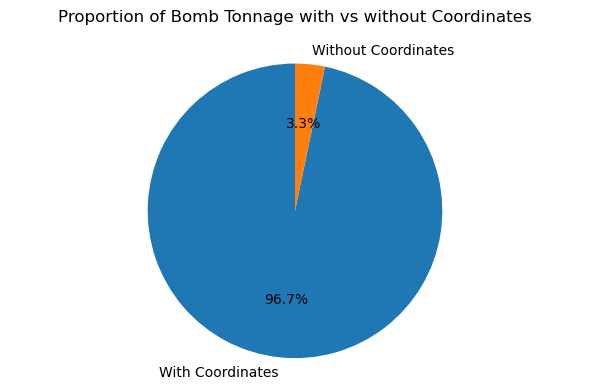

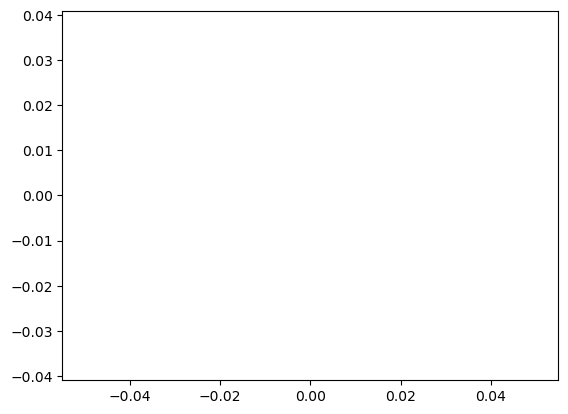

In [85]:

# Plot
labels = ['With Coordinates', 'Without Coordinates']
sizes = [bomb_with_coords, bomb_without_coords]
colors = ['#1f77b4', '#ff7f0e']  # consistent with previous color scheme

fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Proportion of Bomb Tonnage with vs without Coordinates', pad=20)
ax.axis('equal')
plt.tight_layout()
plt.show()

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [72]:
import geopandas as gpd

In [77]:
gdf = gdf.to_crs(epsg=32648)    
adm0 = adm0.to_crs(epsg=32648)

adm0_buffer = adm0.buffer(5000)

gdf_filtered = gdf[gdf.geometry.within(adm0_buffer.union_all())]

# Optional: return to WGS84 for mapping/export
gdf_filtered = gdf_filtered.to_crs(epsg=4326)

In [79]:
# gdf_filtered = gdf_filtered.drop(columns=['Unnamed: 0'])

In [81]:
bomb_in_vn = np.sum(
    gdf_filtered[gdf_filtered['WEAPON_CLASS'] == 'BOMB']['WEAPONTYPEWEIGHT'] *
    gdf_filtered[gdf_filtered['WEAPON_CLASS'] == 'BOMB']['NUMWEAPONSDELIVERED']
) / 2000

all_bombs = np.sum(
    operations[operations['WEAPON_CLASS'] == 'BOMB']['WEAPONTYPEWEIGHT'] *
    operations[operations['WEAPON_CLASS'] == 'BOMB']['NUMWEAPONSDELIVERED']
) / 2000

print(bomb_in_vn / all_bombs)

0.6445618867902214


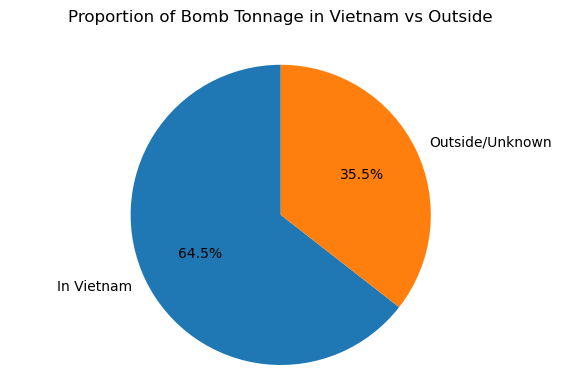

In [84]:
import matplotlib.pyplot as plt

# Assuming bomb_in_vn and all_bombs are already computed
bomb_outside_vn = all_bombs - bomb_in_vn

# Pie chart labels and values
labels = ['In Vietnam', 'Outside/Unknown']
sizes = [bomb_in_vn, bomb_outside_vn]
# colors = ['#2ca02c', '#d62728']  # green for VN, red for outside/unknown

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Proportion of Bomb Tonnage in Vietnam vs Outside', pad=20)
ax.axis('equal')  # Keep pie circular
plt.tight_layout()
plt.show()


In [41]:
operations_with_coords = gdf_filtered

In [42]:
# export_gdf_filtered = gdf_filtered[selected_columns]
# export_gdf_filtered.to_csv('data/ops_coords_5km_vn_border.csv', index=False)

### b. Areas with risk based on strike density
- Here, we will create the following overlays:
    1. ADM1 with mission count
    2. ADM1 with Weapon delivered count
    3. ADM1 with count by each WEAPON_CLASS
    4. Repeat the given graphs with ADM0
- Purpose: To see the desnity of operations in Central Governed City (ADM1) and huyện (district), quận (urban district), thị xã (town), or thành phố thuộc tỉnh (provincial city) (ADM2).

- Performing spatial join to get data points into ADM2 regions

In [43]:
selected_columns_geometry = [
    'TGTLATDD_DDD_WGS84', 'TGTLONDDD_DDD_WGS84', 'MSNDATE', 'NUMWEAPONSDELIVERED', 'NUMOFACFT', 
    'OPERATIONSUPPORTED', 'PERIODOFDAY', 'TGTCOUNTRY', 'TGTWEATHER', 'WEAPON_CLASS', 'YEAR',
    'MFUNC_DESC', 'MFUNC_DESC_CLASS', 'geometry'
]

selected_columns_with_geom = selected_columns + ['geometry']

gdf_operations = operations_with_coords[selected_columns_with_geom].copy()

if gdf_operations.crs != adm1.crs:
    gdf_operations = gdf_operations.to_crs(adm1.crs)

operations_adm1 = gpd.sjoin(gdf_operations, adm1, how='left', predicate='within')
operations_adm2 = gpd.sjoin(gdf_operations, adm2, how='left', predicate='within')

In [44]:
import geopandas as gpd
import pandas as pd

# Aggregate overall mission and weapons delivered counts per ADM1
adm1_agg = operations_adm1.groupby('shapeName').agg(
    mission_count=('shapeName', 'size'),           # count of missions
    weapons_delivered_count=('NUMWEAPONSDELIVERED', 'sum')
).reset_index()

# Aggregate total weapons delivered per ADM1 and weapon class
adm1_weapon_class_counts = operations_adm1.groupby(['shapeName', 'WEAPON_CLASS']).agg(
    weapons_delivered_sum=('NUMWEAPONSDELIVERED', 'sum')
).reset_index()

# Pivot so each weapon class becomes a column of weapons delivered
adm1_weapon_class_pivot = adm1_weapon_class_counts.pivot(
    index='shapeName', columns='WEAPON_CLASS', values='weapons_delivered_sum'
).fillna(0).reset_index()

# Merge overall mission and total weapons delivered with pivoted weapon class delivery counts
adm1_merged = adm1_agg.merge(adm1_weapon_class_pivot, on='shapeName', how='left')

# Merge with ADM1 geometry to prepare for visualization
visualize_adm1_agg = adm1.merge(adm1_merged, on='shapeName', how='left')

In [45]:
adm1_agg.head(2)

,shapeName,mission_count,weapons_delivered_count
0,An Giang,18016,147387
1,Bà Rịa–Vũng Tàu,18306,159226


In [46]:
adm1_weapon_class_pivot.head(2)

WEAPON_CLASS,shapeName,BOMB,GUN,MISSILE,ROCKET,SUPPORT
0,An Giang,95873.0,17625.0,22.0,11278.0,89.0
1,Bà Rịa–Vũng Tàu,96140.0,14805.0,110.0,21707.0,267.0


In [47]:
visualize_adm1_agg.head(2)

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry,mission_count,weapons_delivered_count,BOMB,GUN,MISSILE,ROCKET,SUPPORT
0,An Giang,VN-44,63759600B46141220358660,VNM,ADM1,"POLYGON ((105.18476 10.91406, 105.17936 10.924...",18016.0,147387.0,95873.0,17625.0,22.0,11278.0,89.0
1,Bà Rịa–Vũng Tàu,VN-43,63759600B21811289888982,VNM,ADM1,"POLYGON ((107.00723 10.60597, 107.01135 10.603...",18306.0,159226.0,96140.0,14805.0,110.0,21707.0,267.0


In [48]:
adm2_agg = operations_adm2.groupby('shapeName').agg(
    mission_count=('shapeName', 'size'),
    weapons_delivered_count=('NUMWEAPONSDELIVERED', 'sum')
).reset_index()

adm2_weapon_class_counts = operations_adm2.groupby(['shapeName', 'WEAPON_CLASS']).agg(
    weapons_delivered_sum=('NUMWEAPONSDELIVERED', 'sum')
).reset_index()

adm2_weapon_class_pivot = adm2_weapon_class_counts.pivot(
    index='shapeName', columns='WEAPON_CLASS', values='weapons_delivered_sum'
).fillna(0).reset_index()

adm2_merged = adm2_agg.merge(adm2_weapon_class_pivot, on='shapeName', how='left')

visualize_adm2_agg = adm2.merge(adm2_merged, on='shapeName', how='left')

In [49]:
# visualize_adm1_agg.to_csv('data/adm1_agg.csv', index=False)
# visualize_adm2_agg.to_csv('data/adm2_agg.csv', index=False)

<div style="display: flex; justify-content: space-between; align-items: flex-start;">

  <div style="text-align: center; flex: 1; margin: 0 10px;">
    <img src="graph_images/adm1_agg_weapon_delivered.png" alt="Image 1" style="height: 400px; object-fit: cover;">
    <p>ADM1 map of regions aggregated by weapons delivered</p>
  </div>

  <div style="text-align: center; flex: 1; margin: 0 10px;">
    <img src="graph_images/adm2_agg_weapon_delivered.png" alt="Image 2" style="height: 400px; object-fit: cover;">
    <p>ADM2 map of regions aggregated by weapons delivered</p>
  </div>

</div>


- From this map, we can see that the amount of bombs dropped focuses on the central region of Vietnam, especially Quảng Trị.
- The second most bombed area is the Southeast Region (Đông Nam Bộ)

#### Based on the binning of areas, we can devide into different level of risks, and we use ADM2 because it's more actionable
- We can try to classify the regions by following criteria
  + Total weapon count per ADM2 region
  + Weapon density per 10km2 in an ADM2 region

- Binning based on amount of weapons used on an area of 10km2 for every city

<div style="display: flex; justify-content: space-between; align-items: flex-start;">

  <div style="text-align: center; flex: 1; margin: 0 10px;">
    <img src="graph_images/adm2_agg_weapon_delivered_density.png" alt="Image 2" style="height: 400px; object-fit: cover;">
    <p>ADM2 map of regions aggregated by weapons delivered density per 10km2</p>
  </div>

</div>


- Compared to the map showing the total number of weapons delivered per ADM2 region, the weapons delivery density map reveals that some regions, despite having fewer bombs overall, have a much higher concentration, making them potentially more dangerous.

In [50]:
adm2_weapon_density = adm2.merge(adm2_merged, on='shapeName', how='left')

In [51]:
# Ensure you're working in a projected CRS (for accurate area calculation)
if adm2.crs.to_epsg() != 3857:
    adm2_projected = adm2.to_crs(epsg=3857)
else:
    adm2_projected = adm2.copy()

# Calculate area in square kilometers
adm2_projected['area_km2'] = adm2_projected.geometry.area / 1e6  # m² to km²

# Merge with your aggregated data
adm2_weapon_density = adm2_projected.merge(adm2_merged, on='shapeName', how='left')

# List of columns to compute density for
weapon_cols = [
    'weapons_delivered_count', 'BOMB', 'GUN', 'MISSILE', 'ROCKET', 'SUPPORT'
]

# Compute densities per 10 km²
for col in weapon_cols:
    adm2_weapon_density[f'{col}_density_per_10km2'] = (
        adm2_weapon_density[col] / adm2_weapon_density['area_km2']
    ) * 10

# Keep geometry for plotting
result = adm2_weapon_density[[
    'shapeName', 'geometry', 'area_km2'
] + weapon_cols + [f'{col}_density_per_10km2' for col in weapon_cols]]

# Make sure it's a GeoDataFrame
result = gpd.GeoDataFrame(result, geometry='geometry', crs=adm2_projected.crs)
result = adm2.merge(result, on='shapeName', how='left')
result.to_csv('data/weapon_density_per10km2.csv', index=False)

### c. Areas with risk based on dud rate
- Thanks to the power of modern LLM, we can find the dud rate of weapons in the US bombing data from credible sources by feeding Claude AI the table below and with a simple prompt 
```
Given this CSV of weapons used by the USA Airforce during Vietnam war, find the dudrate for each WEAPONTYPE, that's the primary column. Generatae a CSV with dud rates and add the following columns:
+ DUD_RATE: the dud rate of the weapons (if it is explosive)
+ SOURCE: Source for the dud rate info
```

In [52]:
weapons[['WEAPONTYPE_COMMON_NAME', 'WEAPONTYPE', 'WEAPON_CLASS']].head(5)

,WEAPONTYPE_COMMON_NAME,WEAPONTYPE,WEAPON_CLASS
0,General Purpose Bomb,100 GP,BOMB
1,Megaboller flash powder bomb,1000 G,BOMB
2,An-M65,1000LB GP M-65,BOMB
3,Mark 83 bomb,1000LB MK-83,BOMB
4,AN-M59,1000LB SAP M59,BOMB


#### This is the result made by Claude AI

In [53]:
dud_rates = pd.read_csv('data/dud_rate.csv', encoding='utf-8-sig')
dud_rates.head()

,WEAPONTYPE,WEAPONTYPE_COMMON_NAME,WEAPON_CLASS,DUD_RATE,SOURCE
0,100 GP,General Purpose Bomb,BOMB,10.0,"US DoD UXO Technical Report, 1970"
1,1000 G,Megaboller flash powder bomb,BOMB,3.5,"Military Munitions Assessment Report, 1975"
2,1000LB GP M-65,An-M65,BOMB,10.0,"USAF Explosive Ordnance Report, 1972"
3,1000LB MK-83,Mark 83 bomb,BOMB,5.7,"Naval Weapons Center Study, 1974"
4,1000LB SAP M59,AN-M59,BOMB,12.0,"USAF EOD Historical Analysis, 1973"


In [54]:
dud_rates.iloc[30]

WEAPONTYPE                  40MM MISC METAL
WEAPONTYPE_COMMON_NAME                  NaN
WEAPON_CLASS                            GUN
DUD_RATE                                NaN
SOURCE                    Insufficient data
Name: 30, dtype: object

In [55]:
dud_rates.sort_values('DUD_RATE', ascending=False).head()

,WEAPONTYPE,WEAPONTYPE_COMMON_NAME,WEAPON_CLASS,DUD_RATE,SOURCE
121,CBU-34,CBU-34/A,BOMB,30.0,"Cluster Munitions Assessment Report, 1975"
131,CBU49 AN PR MINE,CBU-49/B,BOMB,30.0,"Cluster Munitions Assessment Report, 1975"
109,CBU24 AN PR/MT (BLU26),CBU-24/B,BOMB,30.0,"Cluster Munitions Assessment Report, 1975"
110,CBU-24/29,CBU-24/B,BOMB,30.0,"Cluster Munitions Assessment Report, 1975"
111,CBU25 AN PR/MT (BLU24),CBU-25/A,BOMB,30.0,"Cluster Munitions Assessment Report, 1975"


In [56]:
dud_rates[dud_rates['DUD_RATE'].isnull()]['SOURCE'].unique()

array(['Not explosive ordnance', 'Insufficient data',
       'Dispenser only, not explosive', 'Guidance system, not explosive',
       'Guidance kit, not explosive itself',
       'Launcher, not explosive itself',
       'Dispenser, not explosive itself'], dtype=object)

In [57]:
dud_rates[dud_rates['SOURCE'] == 'Insufficient data']

,WEAPONTYPE,WEAPONTYPE_COMMON_NAME,WEAPON_CLASS,DUD_RATE,SOURCE
30,40MM MISC METAL,NaN,GUN,NaN,Insufficient data
196,MAO3 NBB,NaN,BOMB,NaN,Insufficient data
250,MLU-108,NaN,BOMB,NaN,Insufficient data
291,XM41UNITS-CAN,NaN,MISSILE,NaN,Insufficient data


- The majority of missing dud rate values are due to the fact that the corresponding weapons are non-explosive, making the dud rate not applicable **Missing not at random (MAR)**. These represent structural missingness. The remaining four entries are **Missing At Random (MAR)**, as there is no apparent systematic reason for their absence.
- We can use this table to assess areas with risks based on dud rate

In [58]:
dud_rates['DUD_RATE'] /= 100

In [68]:
qtmac = pd.read_csv('data/qtmac_data.csv')

In [69]:
qtmac.head()

,location,weapon_class,weapon_count
0,hai lang,cluster bomb,49500
1,hai lang,bomb and carpet bomb,277
2,hai lang,mortar,12002
3,hai lang,rocket,950
4,hai lang,firearm munition,16534


#### Finding the minimum dud rate
- Cite source for formula in document

In [70]:
quangtri = adm1[adm1['shapeName'].str.contains('Quảng Trị', case=False)]
gdf = gdf.to_crs(quangtri.crs)
quangtri_ops = gpd.sjoin(gdf, quangtri, predicate='within', how='inner')

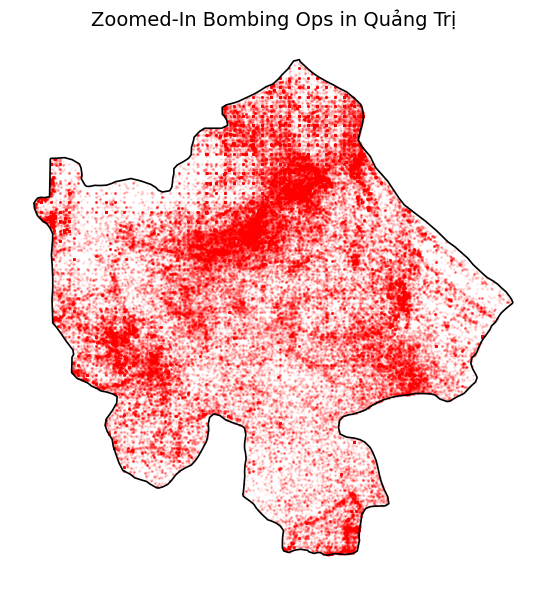

In [71]:
fig2, ax2 = plt.subplots(figsize=(8, 6))

quangtri.boundary.plot(ax=ax2, color='black', linewidth=1.2)
quangtri_ops.plot(ax=ax2, color='red', markersize=1, alpha=0.05) 

ax2.set_title("Zoomed-In Bombing Ops in Quảng Trị", fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()

#### We are going to compare the distribution of different weapons in operation data and QTMAC data

- Some categories in QTMAC doesn't exist in operation data like as they belongs to ground troop. Hence, we can only use certain categories.
- operation_data = ['BOMB', 'ROCKET', 'MISSILE']
- qtmac_data = {'BOMB': ['bomb and carpet bomb', 'cluster bomb'], 'ROCKET': ['rocket']}
- Ground troop weaponsn = ['artillery shell', 'firearm munition', 'fuze', 'grenade', 'mine', 'mortar']

In [72]:
qtmac.groupby('weapon_class')['weapon_count'].sum()

weapon_class
artillery shell         206729
bomb and carpet bomb      1840
cluster bomb            386848
firearm munition        128456
fuze                    122061
grenade                 246057
mine                     12754
mortar                   83583
rocket                    6392
Name: weapon_count, dtype: int64

In [73]:
quangtri_ops['WEAPON_CLASS'].value_counts()

WEAPON_CLASS
BOMB       133566
ROCKET      13107
MISSILE      3565
SUPPORT      2929
GUN          1368
Name: count, dtype: int64

In [74]:
qtmac_bomb_count = qtmac[qtmac['weapon_class'].isin(['bomb and carpet bomb', 'cluster bomb'])]['weapon_count'].sum()
qtmac_rocket_count = qtmac[qtmac['weapon_class'] == 'rocket']['weapon_count'].sum()

bomb_dud_rate = qtmac_bomb_count / np.sum(quangtri_ops[quangtri_ops['WEAPON_CLASS'] == 'BOMB']['NUMWEAPONSDELIVERED'])
rocket_dud_rate = qtmac_rocket_count / np.sum(quangtri_ops[quangtri_ops['WEAPON_CLASS'] == 'ROCKET']['NUMWEAPONSDELIVERED'])

In [75]:
min_dud_rate = pd.Series({
    'bomb' : bomb_dud_rate, 
    'rocket' : rocket_dud_rate
})

min_dud_rate

bomb      0.140103
rocket    0.027768
dtype: float64